# Typical Linear Models

In [ ]:
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl.utils import Merge, Split, Smooth
from nipype.interfaces.fsl.model import Randomise, Cluster, GLM
from nipype.interfaces.freesurfer import FSCommand
from pandas import read_csv

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

#freesurfer setup
fs_dir = '/moochie/Cat/Aggregate_anats/subjects_dir'
FSCommand.set_default_subjects_dir(fs_dir)

#other study-specific variables
project_home = '/home/camachocm2/Analysis/aggregate_anats'
workflow_dir = project_home + '/workflows'
preproc_dir = project_home + '/proc/subj_data'
output_dir = project_home + '/proc/group_data/2factors'
template = preproc_dir + '/sample_template/lcbd_template0.nii.gz'
mask = preproc_dir + '/sample_template/lcbd_template_mask.nii.gz'

# Files for group level analysis
t_contrasts = project_home + '/misc/tcon_f1f3.con'

subject_info = read_csv(project_home + '/results/combined_data_20190311.csv', index_col=0)
subjects_list = subject_info['freesurferID'].tolist()

In [ ]:
# Data Handling Nodes

datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir

grabdata = Node(DataGrabber(template=preproc_dir + '/Final_CT_templateSpace/*/antsCT_CorticalThickness_trans.nii.gz', 
                               sort_filelist=True, 
                               outfields=['data_list']), 
                   name='grabdata')

In [ ]:
def get_cluster_peaks(clusters_file, stat_file):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, unravel_index, max
    from os.path import abspath
    
    # load up clusters
    clusters_nii = load(clusters_file)
    clusters_data = clusters_nii.get_data()
    cluster_labels, cluster_sizes = unique(clusters_data, return_counts=True)
    cluster_sizes = cluster_sizes[cluster_labels>0]
    cluster_labels = cluster_labels[cluster_labels>0]
    
    # set up dataframe
    cluster_info = DataFrame(columns=['clust_num','peak','num_voxels','X','Y','Z'])
    cluster_info['clust_num'] = Series(cluster_labels,index=None)
    
    for i in range(0,len(cluster_labels)):
        # load up stat image
        stat_nii = load(stat_file)
        stat_data = stat_nii.get_data()
        stat_data[clusters_data!=cluster_labels[i]]=0
        location=unravel_index(stat_data.argmax(), stat_data.shape)
        cluster_info.iloc[i,0]=cluster_labels[i]
        cluster_info.iloc[i,1]=max(stat_data)
        cluster_info.iloc[i,2]=cluster_sizes[i]
        cluster_info.iloc[i,3]=location[0]
        cluster_info.iloc[i,4]=location[1]
        cluster_info.iloc[i,5]=location[2]
    
    out_prefix = clusters_file[:-7]
    cluster_info.to_csv(out_prefix + '_peaks.csv')
    cluster_info_file = abspath(out_prefix + '_peaks.csv')
    return(cluster_info_file)

def extract_cluster_betas(cluster_index_file, sample_L1_data, min_clust_size, subject_ids):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, zeros_like, invert
    from nipype.interfaces.fsl.utils import ImageMeants
    from os.path import abspath, basename
    
    sample_data = DataFrame(subject_ids, index=None, columns=['Subject'])
    
    cluster_nifti = load(cluster_index_file)
    cluster_data = cluster_nifti.get_data()
    clusters, cluster_sizes = unique(cluster_data, return_counts=True)
    cluster_sizes = cluster_sizes[clusters>0]
    clusters = clusters[clusters>0]
    clusters = clusters[cluster_sizes>min_clust_size]
    cluster_sizes = cluster_sizes[cluster_sizes>min_clust_size]
    ind_filename = basename(cluster_index_file) 
    out_prefix = ind_filename[:-7]
    
    for clust_idx in clusters:
        temp = zeros_like(cluster_data)
        temp[cluster_data==clust_idx] = 1
        temp_nii = Nifti1Image(temp,cluster_nifti.affine)
        temp_file = 'temp_clust_mask.nii.gz'
        save(temp_nii, temp_file)

        eb = ImageMeants()
        eb.inputs.in_file = sample_L1_data
        eb.inputs.mask = temp_file
        eb.inputs.out_file = 'L1vals.txt'
        eb.run()
        L1vals = open('L1vals.txt').read().splitlines()
        sample_data['clust' + str(clust_idx)] = Series(L1vals, index=sample_data.index)
    
    sample_data.to_csv(out_prefix+'_extracted_L1vals.csv')
    extracted_L1vals_csv = abspath(out_prefix+'_extracted_L1vals.csv')

    return(extracted_L1vals_csv)

def calculate_tstat_min(subject_data_list):
    from scipy.stats import t
    
    N_subs = len(subject_data_list)
    dof = N_subs - 1
    tstat_threshold = t.ppf(1-0.025, dof)
    
    return(tstat_threshold)

def sub_lists(subjects_df, data_list):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from subprocess import check_call
    from os.path import abspath
    from nipype.interfaces.fsl import Merge
    
    data_list = sorted(data_list)
    usable_subs = subjects_df[subjects_df['CT_QC']==1]
    subjects_list = usable_subs['freesurferID'].tolist()
    Factor1 = usable_subs['Factor1'].tolist()
    Factor2 = usable_subs['Factor2'].tolist()
    Factor3 = usable_subs['Factor3'].tolist()
    Factor4 = usable_subs['Factor4'].tolist()
    subjects_ages = usable_subs['Age_yrs'].tolist()
    male = usable_subs['male'].tolist()
    seq1 = usable_subs['seq1'].tolist()
    seq2 = usable_subs['seq2'].tolist()
    seq3 = usable_subs['seq3'].tolist()
    seq4 = usable_subs['seq4'].tolist()
    eTIV = usable_subs['eTIV'].tolist()

    final_data_list = []
    final_subjects_list = []
    text_file = open('temp_text.txt','w')

    for a in range(0,len(subjects_list)):
        for file in data_list:
            if '/' + subjects_list[a] + '/' in file:
                final_data_list.append(file)
                final_subjects_list.append(subjects_list[a])
                #text_file.write('{0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10}\n'.format(Factor1[a], Factor2[a], Factor3[a], 
                #                                                                        Factor4[a],subjects_ages[a], male[a], 
                #                                                                        seq1[a], seq2[a], seq3[a],seq4[a], 
                #                                                                        eTIV[a]))
                text_file.write('{0} {1} {2} {3} {4} {5} {6} {7} {8}\n'.format(Factor1[a], Factor3[a], subjects_ages[a],
                                                                               male[a], seq1[a], seq2[a], seq3[a],seq4[a],
                                                                               eTIV[a]))
                
    text_file.close()

    file = abspath('temp_text.txt')
    check_call(['Text2Vest',file,'design.mat'])
    design_file = abspath('design.mat')

    me=Merge()
    me.inputs.dimension='t'
    me.inputs.in_files=final_data_list
    me.inputs.merged_file='data_merged.nii.gz'
    me.run()

    final_data = abspath('data_merged.nii.gz')

    return(final_data,design_file,final_subjects_list)

In [ ]:
# Analysis Nodes

select_usable_data = Node(Function(input_names=['subjects_df', 'data_list'],
                                   output_names=['final_data','design_file','final_subjects_list'], 
                                   function=sub_lists), 
                          name = 'select_usable_data')
select_usable_data.inputs.subjects_df = subject_info

smooth = Node(Smooth(fwhm=4),name='smooth')

#model = Node(GLM(mask=mask, 
#                 out_p_name='pvals.nii.gz',
#                 out_t_name='tstat.nii.gz', 
#                 contrasts=t_contrasts), 
#             name='model')

model = Node(Randomise(mask=mask, 
                       tfce=False,
                       num_perm=1000,
                       tcon=t_contrasts), 
             name='model')

split = Node(Split(dimension='t'), name='split')

calc_threshold = Node(Function(input_names=['subject_data_list'], 
                               output_names=['tstat_threshold'], 
                               function=calculate_tstat_min), 
                      name='calc_threshold')

cluster = MapNode(Cluster(out_localmax_txt_file = 'cluster_stats.txt',
                          dlh=4, 
                          pthreshold=0.05, 
                          volume=1472512,
                          out_index_file='clusters.nii.gz'), 
                  name='cluster', iterfield=['in_file'])

get_peaks = MapNode(Function(input_names=['clusters_file', 'stat_file'], 
                             output_names=['cluster_info_file'], 
                             function=get_cluster_peaks), 
                    name='get_peaks', iterfield=['clusters_file', 'stat_file'])

get_L1vals = MapNode(Function(input_names=['cluster_index_file', 'sample_L1_data', 
                                           'min_clust_size', 'subject_ids'], 
                              output_names=['extracted_L1vals_csv'], 
                              function=extract_cluster_betas), 
                     name='get_L1vals', iterfield=['cluster_index_file'])
get_L1vals.inputs.min_clust_size=25

In [ ]:
# Analysis workflow

grouplevel = Workflow(name='grouplevel_2factors')

grouplevel.connect([(grabdata, select_usable_data,[('data_list', 'data_list')]),
                    (select_usable_data, smooth, [('final_data','in_file')]),
                    (smooth, model, [('smoothed_file','in_file')]),
                    (select_usable_data, model, [('design_file','design_mat')]),
                    #(select_usable_data, calc_threshold, [('final_subjects_list','subject_data_list')]),
                    #(select_usable_data, get_L1vals, [('final_subjects_list','subject_ids')]),
                    #(calc_threshold, cluster, [('tstat_threshold','threshold')]),
                    
                    #(model, cluster, [('tstat_files','in_file')]),
                    #(cluster, get_peaks, [('index_file','clusters_file')]),
                    #(model, get_peaks, [('tstat_files','stat_file')]),
                    #(cluster, get_L1vals ,[('index_file','cluster_index_file')]),
                    #(select_usable_data, get_L1vals, [('final_data','sample_L1_data')]),
                    
                    #(get_peaks, datasink, [('cluster_info_file','cluster_stats')]),
                    #(get_L1vals, datasink, [('extracted_L1vals_csv','cluster_L1vals')]),
                    (model, datasink, [('tstat_files','tstat_files')])
                    #(cluster, datasink, [('index_file','clusters_file')])
                   ])

grouplevel.base_dir = workflow_dir
grouplevel.write_graph(graph2use='flat')
grouplevel.run('MultiProc', plugin_args={'n_procs': 2})

# Mixed Effects Models

In [ ]:
# Import stuff
from os.path import join
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.interfaces.fsl.utils import Merge, ImageMeants, Split
from nipype.interfaces.fsl.model import Randomise, Cluster
from nipype.interfaces.freesurfer.model import Binarize
from nipype.interfaces.fsl.maths import ApplyMask, Threshold
from pandas import DataFrame, Series

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI')

# Set study variables
analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
firstlevel_dir = analysis_home + '/proc/firstlevel'
secondlevel_dir = analysis_home + '/proc/secondlevel'
workflow_dir = analysis_home + '/workflows'
template_dir = analysis_home + '/templates'
MNI_template = template_dir + '/MNI152_T1_1mm_brain.nii.gz'
MNI_mask = template_dir + '/MNI152_T1_3mm_mask.nii.gz'

#pull subject info 
subject_info = analysis_home + '/misc/subjs.csv'

conditions = ['punish','neutral']
seed_names = ['L_amyg','R_amyg']

# Group analysis models (predicting FC)
models = ['brain ~ ageMC + sex + ageMC*sex', 
          'brain ~ invAgeMC + sex + invAgeMC*sex']

model_names = ['linearAge', 'inverseAge']

terms = ['age', 'sex', 'ageSexInteract']

In [ ]:
# LMEM for MRI data (3D nifti data)
def mri_lmem(model, mask, subject_dataframe, subject_files, grouping_variable):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)

    from os import getcwd
    from os.path import abspath
    import statsmodels.formula.api as smf
    from nibabel import load, save, Nifti1Image
    from numpy import array, empty_like, stack, nditer, zeros_like, zeros
    from pandas import DataFrame, read_csv, Series, concat
    from warnings import filterwarnings
    filterwarnings("ignore")

    working_dir = getcwd() + '/'
    subj_data = read_csv(subject_dataframe, header=0, index_col=0)

    # Load the brain data
    brain_niftis = load(subject_files)
    brain_data_4D = brain_niftis.get_data()

    # Load the mask
    mask_nifti = load(mask)
    mask = mask_nifti.get_data()

    ## Preallocate the output arrays
    # for the model
    BIC_data = zeros_like(mask).astype(float)
    AIC_data = zeros_like(mask).astype(float)
    pval_intercept_data = zeros_like(mask).astype(float)
    pval_age_data = zeros_like(mask).astype(float)
    pval_sex_data = zeros_like(mask).astype(float)
    pval_ageSexInteract_data = zeros_like(mask).astype(float)
    # per subject
    residuals_data = zeros_like(brain_data_4D).astype(float)
    pred_values_data = zeros_like(brain_data_4D).astype(float)

    # Set up the actual loops to pull in subject data and do the modeling
    for x in range(0,mask.shape[0]):
        for y in range(0,mask.shape[1]):
            for z in range(0,mask.shape[2]):
                if mask[x][y][z] == 1:
                    voxel = zeros(brain_data_4D.shape[3])
                    for a in range(0,brain_data_4D.shape[3]):
                        voxel[a] = brain_data_4D[x][y][z][a]
                    voxel = Series(voxel, index=subj_data.index, name='brain')
                    data = concat([voxel, subj_data],axis=1)
                    mlm = smf.mixedlm(model, data, groups=data[grouping_variable])
                    mod = mlm.fit()
                    pval_intercept_data[x][y][z] = 1 - mod.pvalues[0]
                    pval_age_data[x][y][z] = 1 - mod.pvalues[1]
                    pval_sex_data[x][y][z] = 1 - mod.pvalues[2]
                    pval_ageSexInteract_data[x][y][z] = 1 - mod.pvalues[3]
                    BIC_data[x][y][z] = mod.bic
                    AIC_data[x][y][z] = mod.aic
                    residuals = mod.resid
                    pred_values = Series(mod.predict(), index = subj_data.index)
                    for d in range(0,brain_data_4D.shape[3]):
                        residuals_data[x][y][z][d] = residuals.tolist()[d]
                        pred_values_data[x][y][z][d] = pred_values.tolist()[d]

                
    # Save the ouputs as nifti files
    output_data = [BIC_data, AIC_data, pval_intercept_data, pval_age_data,
                    pval_sex_data, pval_ageSexInteract_data, residuals_data, 
                    pred_values_data]
    output_niftis = [Nifti1Image(result, mask_nifti.affine) for result in output_data]
    
    output_filenames = ['BICs.nii','AICs.nii','pval_intercept_data.nii',
                        'pval_age_data.nii','pval_sex_data.nii',
                        'pval_ageSexInteract_data.nii','residuals_data.nii',
                        'pred_values_data.nii']
    for e in range(0,len(output_niftis)):
        save(output_niftis[e], working_dir + output_filenames[e])
    
    output_volumes = [abspath(output_filenames[0]),
                      abspath(output_filenames[1]),
                      abspath(output_filenames[2]), 
                      abspath(output_filenames[3]), 
                      abspath(output_filenames[4]), 
                      abspath(output_filenames[5]), 
                      abspath(output_filenames[6]), 
                      abspath(output_filenames[7])]
    
    return(output_volumes)

In [ ]:
## Data handling nodes

conditionsource = Node(IdentityInterface(fields=['condition','seed']),
                       name='conditionsource')
conditionsource.iterables = [('condition',conditions),('seed', seed_names)]

# Grab the subject beta maps 
time_template = {'beta_maps':firstlevel_dir + '/smoothedMNI_conn_beta/*/%s/%s/betas_flirt_smooth_masked.nii'}
betamap_grabber = Node(DataGrabber(sort_filelist=True,
                                   field_template = time_template,
                                   base_directory=firstlevel_dir,
                                   template=firstlevel_dir + '/smoothedMNI_conn_beta/*/%s/%s/betas_flirt_smooth_masked.nii',
                                   infields=['condition','seed'],
                                   template_args={'beta_maps':[['condition','seed']]}), 
                       name='betamap_grabber')

# Sink relavent data
substitutions = [('_condition_',''),
                 ('_seed_',''), 
                 ('brain~ageMC+sex+ageMC*sex','linearAge'),
                 ('brain~invAgeMC+sex+invAgeMC*sex','inverseAge')]
datasink = Node(DataSink(substitutions=substitutions, 
                         base_directory=secondlevel_dir,
                         container=secondlevel_dir), 
                name='datasink')

In [ ]:
## Analysis nodes

#Merge subject files together
merge = Node(Merge(dimension='t'), name='merge')

# Linear mixed effects modeling
lmemodel = Node(Function(input_names = ['model', 'mask', 'subject_dataframe', 
                                        'subject_files', 'grouping_variable'], 
                         output_names = ['output_volumes'], 
                         function=mri_lmem), 
                name='lmemodel')
lmemodel.iterables = [('model', models)]
lmemodel.inputs.mask = MNI_mask
lmemodel.inputs.subject_dataframe = subject_info
lmemodel.inputs.grouping_variable = 'Timepoint'

# Mask the file to only significant voxels for clustering
mask_stat = Node(Binarize(), name = 'mask_stat')

# Cluster the results
cluster_results = MapNode(Cluster(threshold=0.95,
                                  out_index_file=True,
                                  out_localmax_txt_file=True),
                          name='cluster_results', 
                          iterfield = ['in_file'])

In [ ]:

LMEManalysisflow = Workflow(name='LMEManalysisflow')
LMEManalysisflow.connect([(conditionsource, betamap_grabber, [('condition','condition'),
                                                              ('seed','seed')]),
                          (betamap_grabber, merge, [('beta_maps','in_files')]),
                          (merge, lmemodel, [('merged_file','subject_files')]),
                          (merge, datasink, [('merged_file','merged_subj_betas')]),
                          (lmemodel, datasink, [('output_volumes','output_volumes')])
                         ])
#LMEManalysisflow.base_dir = workflow_dir
#LMEManalysisflow.write_graph(graph2use='flat')
#LMEManalysisflow.run('MultiProc', plugin_args={'n_procs':2})

In [ ]:
def threshold_clusters(cluster_index):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)

    from os import getcwd
    from os.path import abspath
    from nibabel import load, save, Nifti1Image
    from numpy import unique, amax, stack, zeros_like

    cluster_min = 20
    nifti = load(cluster_index)
    data = nifti.get_data()
    clust_labels, vox_count = unique(data, return_counts=True)
    clust_labels = clust_labels.tolist()
    vox_count = vox_count.tolist()

    iter = 0
    for i in range(0, len(clust_labels)):
        if vox_count[i] < cluster_min:
            del(clust_labels[i-iter])
            iter = iter +1

    clust_labels = clust_labels[1:]
    num_clusters = len(clust_labels)

    cluster_masks = []
    for a in range(0,num_clusters):
        temp = zeros_like(data)
        temp[data==clust_labels[a]] = 1
        cluster_masks.append(temp)

    cluster_masks_4D = stack(cluster_masks,axis=3)
    cluster_masks_nifti = Nifti1Image(cluster_masks_4D, nifti.affine)
    save(cluster_masks_nifti, 'new_clust_index.nii')
    newcluster_index = abspath('new_clust_index.nii')
    return(newcluster_index)


def finalize_models(cluster, template, betas_text_file, subj_data, model_name):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    import statsmodels.formula.api as smf
    from pandas import DataFrame, Series, concat, read_table, read_csv
    from ggplot import *
    from warnings import filterwarnings
    filterwarnings("ignore")
    import sys
    from nilearn import plotting
    
    #determine which model to use
    if model_name=='linearAge':
        model = 'brain ~ ageMC + sex + ageMC*sex'
    elif model_name=='inverseAge':
        model = 'brain ~ invAgeMC + sex + invAgeMC*sex'
        
    origstdout = sys.stdout
    sys.stdout = open('modelsummary.txt', 'w')

    #organize data into dataframe for modeling
    subj_data = read_csv(subj_data, header=0, index_col=0)
    brain_data = read_table(betas_text_file, header=None, names='brain', index_col=None)
    data = concat([brain_data, subj_data],axis=1)
    # do the modeling
    mlm = smf.mixedlm(model, data, groups=data[grouping_variable])
    mod = mlm.fit()
    print(mod.summary())
    sys.stdout = origstdout
    close('modelsummary.txt')
    summary_file = abspath('modelsummary.txt')
    
    # plot the model results
    figure = ggplot(data, aes(x='age',y='brain') + theme_classic() + 
                    geom_point() + geom_smooth(method=lm,se=True, size=2))
    figure.save('plot.svg')
    figure_file = abspath('plot.svg')
    
    # make a picture of the brain cluster
    display = plotting.plot_anat(anat_img = template, display_mode='x')
    display.add_overlay(cluster, plotting.cm.purple_green, threshold=1)
    display.savefig('clusterpic.png')
    display.close()
    clusterpic_file = abspath('clusterpic.png')
    
    outputs = [summary_file, figure_file, clusterpic_file]
    
    return(outputs)

In [ ]:
# Grab data outputs from the LMEMs
infosource = Node(IdentityInterface(fields=['condition','seed','term','model']),
                  name='conditionsource')
infosource.iterables = [('condition', conditions), 
                        ('seed', seed_names), 
                        ('term', terms), 
                        ('model', model_names)]

lme_template = {'pval_vol': secondlevel_dir + '/output_volumes/{condition}{seed}/_model_{model}/pval_{term}_data.nii', 
                'subj_beta_data': secondlevel_dir + '/merged_betas/betas_merged.nii'}            
lme_datagrabber = Node(SelectFiles(lme_template), name='lme_datagrabber') 

# Threshold out nonsignificant voxels
threshold = Node(Threshold(thresh=0.95), name='threshold')

# Cluster the remaining volumes
cluster = Node(Cluster(threshold=0.95, 
                       out_index_file=True, 
                       use_mm=True,
                       minclustersize=True,
                       peak_distance=6), 
               name='cluster')

# remove small clusters
cluster_min = Node(Function(input_names=['cluster_index'], 
                            output_names=['newcluster_index'], 
                            function=threshold_clusters), 
                   name='cluster_min')

# Split the clusters
split = Node(Split(dimension='t'),
             name='split')

# Extract mean connectivity per cluster
pull_mean_betas = MapNode(ImageMeants(out_file='mean_connectivity.txt'), 
                          name= 'pull_mean_betas', 
                          iterfield=['mask'])
                         

# graph the connectivity against age and re-do the linear models
finalize_models = MapNode(Function(input_names=['cluster','template','betas_text_file','subj_data', 'model_name'], 
                                   output_names=['outputs'], 
                                   function=finalize_models),
                          name='finalize_models', 
                          iterfield=['betas_text_file'])
finalize_models.inputs.subj_data=subject_info
finalize_models.inputs.template=MNI_template

In [ ]:

clusterflow = Workflow(name='clusterflow')
clusterflow.connect([(infosource, lme_datagrabber, [('condition','condition'),
                                                    ('seed','seed'),
                                                    ('term','term'),
                                                    ('model','model')]),
                     (lme_datagrabber,threshold, [('pval_vol','in_file')]),
                     (threshold, cluster, [('out_file','in_file')]),
                     (cluster, cluster_min, [('index_file','cluster_index')]),
                     (cluster_min, split, [('newcluster_index','in_file')]),
                     (split, pull_mean_betas, [('out_files','mask')]),
                     (lme_datagrabber, pull_mean_betas, [('subj_beta_data','in_file')]),
                     
                     (pull_mean_betas, datasink, [('out_file','beta_values')]),
                     (cluster, datasink, [('index_file','cluster_index_file'),
                                          ('localmax_txt_file','cluster_localmax_txt_file')]),
                     (split,datasink,[('out_files','final_clusters')])
                    ])
clusterflow.base_dir = workflow_dir
clusterflow.write_graph(graph2use='flat')
clusterflow.run('MultiProc', plugin_args={'n_procs':2})

In [87]:
def extract_cluster_betas(cluster_file, sample_L1_data, clust_name, cluster_vals):
    from pandas import DataFrame, Series, read_csv
    from nipype.interfaces.fsl.utils import ImageMeants
    
    sample_data = read_csv(cluster_vals, index_col=0)

    out_prefix = clust_name
    
    eb = ImageMeants()
    eb.inputs.in_file = sample_L1_data
    eb.inputs.mask = cluster_file
    eb.inputs.out_file = 'L1vals.txt'
    eb.run()
    L1vals = open('L1vals.txt').read().splitlines()
    sample_data[clust_name] = Series(L1vals, index=sample_data.index)
    sample_data.to_csv(cluster_vals)
    

In [89]:
output='/Users/catcamacho/Box/Conferences/20190321_SRCD/talk/1factor/'
cluster_vals=output+'clusters_extracted_L1vals.csv'
clust_files=[output+'LIPS_ClusterMask_randomise_tstat1_x=4.252129e+01_y=-2.092878e+01_z=3.774994e+01_59voxels.nii', 
             output+'LITG_ClusterMask_randomise_tstat1_x=4.952129e+01_y=7.123242e-02_z=-2.325006e+01_190voxels.nii', 
             output+'PSTS_ClusterMask_randomise_tstat1_x=5.052129e+01_y=-2.392877e+01_z=1.274994e+01_72voxels.nii', 
             output+'RIFG_ClusterMask_randomise_tstat1_x=-5.047871e+01_y=1.207123e+01_z=1.774995e+01_74voxels.nii', 
             output+'RITG_ClusterMask_randomise_tstat1_x=-2.447871e+01_y=-1.792877e+01_z=-1.425006e+01_109voxels.nii']
clust_names=['LIPS','LITG','PSTS','RIFG','RITG']
sample_data = output + 'data_merged_smooth.nii.gz'

for a in range(0,5):
    extract_cluster_betas(clust_files[a], sample_data, clust_names[a], cluster_vals)

In [90]:
from pandas import read_csv
thick_data = read_csv(cluster_vals, index_col=0)
full_data = read_csv(output+'all_data_20190320.csv', index_col=0)
full_data = full_data.merge(thick_data, on='freesurferID',how='outer')
#other_data = read_csv(output+'combined_data_20190311.csv', index_col=0)
#vol_data = read_csv(output+'residual_complete_data.csv', index_col=0)
#full_data = thick_data.merge(other_data, on='freesurferID',how='outer')
#full_data = full_data.merge(vol_data, on='freesurferID',how='outer')
full_data.to_csv(output+'all_data_20190320.csv')

In [91]:
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt

data=read_csv(output+'all_data_20190320.csv',index_col=0)
data.columns

Index(['freesurferID', 'eTIV', 'Left-Putamen', 'Right-Putamen',
       'Left-Pallidum', 'Right-Pallidum', 'Left-Caudate', 'Right-Caudate',
       'Left-Accumbens-area', 'Right-Accumbens-area', 'activity_level',
       'anger_frustration', 'attention_focusing', 'discomfort', 'soothability',
       'fear', 'high_intensity_pleasure', 'impulsivity', 'inhibitory_control',
       'low_intensity_pleasure', 'perceptual_sensitivity', 'sadness',
       'shyness', 'MAP_Temper_Loss', 'MAP_Noncompliance',
       'MAP_General_Aggression', 'MAP_Low_Concern', 'CBCL_internalizing',
       'CBCL_externalizing', 'activity_level_std', 'anger_frustration_std',
       'attention_focusing_std', 'discomfort_std', 'soothability_std',
       'fear_std', 'high_intensity_pleasure_std', 'impulsivity_std',
       'inhibitory_control_std', 'low_intensity_pleasure_std',
       'perceptual_sensitivity_std', 'sadness_std', 'shyness_std', 'Factor1',
       'Factor2', 'Factor3', 'Factor4', 'Study', 'Sequence Version', 's

In [154]:

from statsmodels.formula.api import ols
screg = ['res_putamen', 'res_pall']
region=['LIPS', 'LITG', 'PSTS', 'RIFG', 'RITG']
#for a in range(0,2):
#    for b in range(0,4):
#        print(screg[a]+ ' '+region[b]+' '+str(spearmanr(data[screg[a]],data[region[b]],nan_policy='omit')))
#        model = ols('CBCL_externalizing ~ '+region[b]+' + '+region[b]+'*Factor1 + Age_yrs + eTIV + male', 
#data).fit()
#        print(model.summary())
        
#print(spearmanr(data['PSTS'],data['CBCL_externalizing'],nan_policy='omit'))
#print(spearmanr(data['PSTS'],data['Factor1'],nan_policy='omit'))
print(spearmanr(data['CBCL_externalizing'],data['res_putamen'],nan_policy='omit'))
print(spearmanr(data['CBCL_externalizing'],data['res_pall'],nan_policy='omit'))


model = ols('CBCL_externalizing ~ PSTS + PSTS*Factor1 + Age_yrs + eTIV + male', data).fit()
print(model.summary())


SpearmanrResult(correlation=0.10606083428992695, pvalue=0.21738251392701255)
SpearmanrResult(correlation=0.004924202940568422, pvalue=0.9544587165566931)
                            OLS Regression Results                            
Dep. Variable:     CBCL_externalizing   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     24.12
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           2.23e-18
Time:                        10:57:35   Log-Likelihood:                -452.38
No. Observations:                 123   AIC:                             918.8
Df Residuals:                     116   BIC:                             938.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|

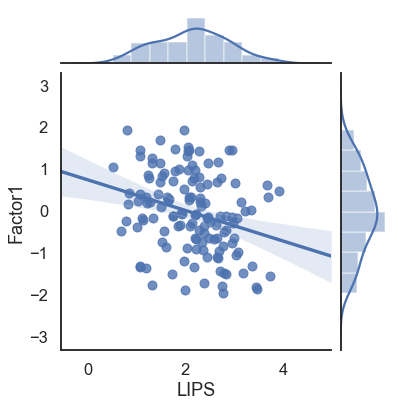

In [155]:
sns.set(context='talk',style='white')
sns.jointplot('LIPS','Factor1',data=data, kind='reg')
plt.savefig(output+'IPL_f1_correlation.svg')
from scipy.stats import spearmanr
#region=['LIPS', 'LITG', 'PSTS', 'RIFG', 'RITG']
#for a in region:
#    print(spearmanr(data[a],data['CBCL_externalizing'],nan_policy='omit'))

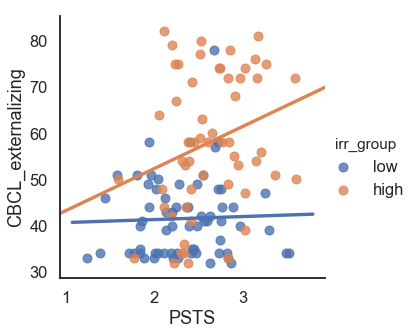

In [153]:
def group_assign(c):
    if c['Factor1']<=0:
        return 'low'
    elif c['Factor1']>0:
        return 'high'
sns.set(context='talk', style='white')

data['irr_group'] = data.apply(group_assign, axis=1) 
sns.lmplot(x='PSTS',y='CBCL_externalizing',hue='irr_group', data=data, ci=None)
plt.savefig(output+'irr_PSTS_interact.svg')

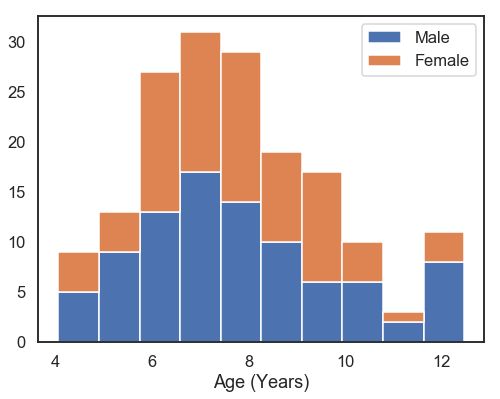

In [119]:
males= data[data['male']==1]
females=data[data['male']==0]
plt.figure(figsize=(8,6))
plt.hist([males['Age_yrs'],females['Age_yrs']], bins=10, stacked=True, 
         label=['Male','Female'])
plt.legend()
plt.xlabel('Age (Years)')
plt.savefig(output + 'age_sex_hist.svg')

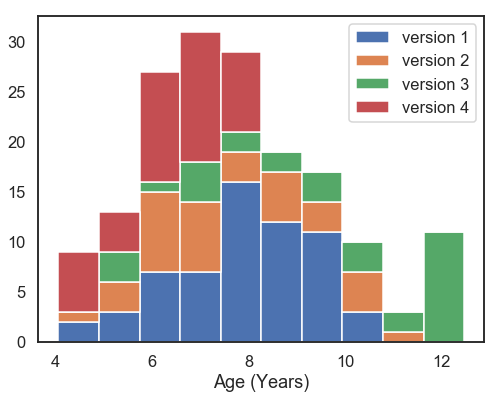

In [120]:
seq1 = data[data['seq1']==1]
seq2 = data[data['seq2']==1]
seq3 = data[data['seq3']==1]
seq4 = data[data['seq4']==1]
plt.figure(figsize=(8,6))
plt.hist([seq1['Age_yrs'],seq2['Age_yrs'],seq3['Age_yrs'],seq4['Age_yrs']],bins=10,
         stacked=True, label=['version 1', 'version 2','version 3','version 4'])
plt.legend()
plt.xlabel('Age (Years)')
plt.savefig(output + 'age_sequence_hist.svg')